<img align="right" style="max-width: 200px; height: auto" src="./assets/logo.png">

## Detection of Accounting Anomalies using Deep-Learning

AAA's Intensive Data and Analytics Summer Workshop III, 2022

The master class environment of the **"Detection of Accounting Anomalies using Deep-Learning"** of the **Intensive Data and Analytics Summer Workshop** is based on Jupyter Notebooks (https://jupyter.org), which allow to perform a variety of statistical evaluations and data analyses.

<img align="center" style="max-width: 900px; height: auto" src="./assets/banner.png">

In this master class, we will use Jupyter Notebook to implement and apply an initial **machine learning based audit analysis procedures** namely the Deep Autoencoder Neural Network based anomaly detection. Unlike standard feedforward neural networks, AENN's learn how to **encode** the input data into a low dimensional representation.  At the same time, the AENN learns how to **decode** the original data back from the encoded representation. The decoded data usually referred to as "reconstruction", should match the original input as closely as possible.

The figure below illustrates a high-level view on the machine learning process we aim to establish in this master class.

<img align="center" style="max-width: 900px" src="./assets/process.png">

We will use the functionality of the `PyTorch` library to implement and train an autoencoder neural network. The network will be trained to learn the characteristics of historical **accounting data**, usually referred to as "journal entries." Once the model is trained, we will apply it to detect anomalous journal entries contained in the dataset. Finally, we will inspect the low-dimensional representations of each journal entry to interpret the detection results.

As always, pls. don't hesitate to ask all your questions either during the master class or send us an email via marco (dot) schreyer (at) unisg (dot) ch.

## Master Class Objectives:

After today's master class, you should be able to:

>1. Understand the **basic concepts, intuitions and major building blocks** of autoencoder neural networks.
>2. **Pre-process** categorical financial data to learn a model of its characteristics and pattern.
>3. Apply autoencoder neural networks to **detect anomalies** in large-scale financial data.
>4. **Interpret the detection results** of the network as well as its reconstruction loss.

But before we start let's watch a brief motivational video published in 2019 by **OpenAI** on solving a rubik's cube with a robot hand using deep neural networks. This underpins that learning computer programs rather than programming a computer program become the new paradigm:

In [1]:
from IPython.display import YouTubeVideo
# OpenAI: Solving Rubik’s Cube with a Robot Hand
# YouTubeVideo('x4O8pojMF0w', width=800, height=400)

## 1. Introduction & Motivation

The Association of Certified Fraud Examiners estimates in its Global Fraud Study 2016 [1] that the typical organization loses 5% of its annual revenues due to fraud. According to Joseph T. Wells [2] the term **"fraud"** refers to, **"the abuse of one's occupation for personal enrichment through the deliberate misuse of an organization's resources or assets"**. 

A similar more recent study, conducted by the auditors of PwC, revealed that 30% of the study respondents experienced losses of between USD 100,000 and USD 5 million [3] in the last 24 months. The study also showed that financial statement fraud caused by far the greatest median loss of the surveyed fraud schemes.

### Classification of Financial Anomalies

When conducting a detailed examination of real-world journal entries, usually recorded in large-scaled Accounting Information Systems (AIS) or Enterprise Ressource Planning (ERP) systems, two common characteristics can be observed:

> - specific transactions attributes exhibit **a wide variety of distinct attribute values**, e.g., customer information, posted sub-ledgers, amount data, and 
> - the transactions exhibit **strong dependencies between specific attribute values** e.g., between customer information and type of payment, posting type, and general ledgers. 

Derived from this observation we distinguish two classes of anomalous journal entries, namely **"global"** and **"local" anomalies** as illustrated in **Figure 1** below:

<img align="middle" style="max-width: 800px; height: auto" src="./assets/anomalies.png">

**Figure 1:** Illustrative example of global and local anomalies portrait in a feature space of the two transaction features "Posting Amount" (Feature 1) and "Posting Positions" (Feature 2).

***Global Anomalies***, are financial transactions that exhibit **unusual or rare individual attribute values**. These anomalies usually relate to highly skewed attributes, e.g., seldom posting users, rarely used ledgers, or unusual posting times. Traditionally "red-flag" tests performed by auditors during annual audits are designed to capture those types of anomalies. However, such tests might result in a high volume of false-positive alerts due to, e.g., regular reverse postings, provisions, and year-end adjustments usually associated with a low fraud risk.

***Local Anomalies***, are financial transactions that exhibit an **unusual or rare combination of attribute values** while the individual attribute values occur quite frequently e.g. exceptional accounting records. This type of anomaly is significantly more challenging to detect since perpetrators intend to disguise their activities trying to imitate a normal behavior. As a result, such anomalies usually pose a high fraud risk since they might correspond to, e.g., misused user accounts, irregular combinations of general ledger accounts and posting keys that don't follow a usual activity pattern.

## 2. Setup of the Jupyter Notebook Environment

Before we start, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will mostly use the `PyTorch`, `NumPy`, `Sklearn`, `Matplotlib`, `Seaborn`, and a few utility libraries throughout the master class:

In [2]:
# import python data science and utility libraries
import os, sys, itertools, urllib, io
import datetime as dt
import pandas as pd
import pandas_datareader as dr
import numpy as np

Import the Python machine / deep learning libraries:

In [3]:
# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader

Import Python plotting libraries and set general plotting parameters:

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

Enable notebook matplotlib inline plotting:

In [5]:
%matplotlib inline

Filter and suppress potential library warnings, for example due to library enhancements: 

In [6]:
import warnings

# set the warning filter flag to ignore warnings
warnings.filterwarnings('ignore')

Create a structure of notebook sub-directories inside of the current working directory (1) the data as well as (2) the trained neural network models:

In [7]:
# create the data sub-directory
data_directory = './02_data'
if not os.path.exists(data_directory): os.makedirs(data_directory)
    
# create the results sub-directory
results_directory = './03_results'
if not os.path.exists(results_directory): os.makedirs(results_directory)

# create the models sub-directory
models_directory = './04_models'
if not os.path.exists(models_directory): os.makedirs(models_directory) 

Set a random seed value to obtain reproducable results:

In [8]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed CPU

Enable GPU computing by setting the `device` flag and init a `CUDA` seed:

In [9]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] notebook with \'{}\' computation enabled'.format(str(now), str(device)))

[LOG 2022.01.25-12:26:29] notebook with 'cpu' computation enabled


Also, let's display information about the potential GPUs running on the server:

In [10]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


Let's execute the cell below to display information about the `Python` and `PyTorch` version running on this notebook or compute server:

In [11]:
# print current Python version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 2022.01.25-12:26:29] The Python version: 3.8.5 (default, Jul 21 2020, 10:48:26) 
[Clang 11.0.3 (clang-1103.0.32.62)]


In [12]:
# print current PyTorch version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 2022.01.25-12:26:29] The PyTorch version: 1.8.1


## 3. Dataset Download, Data Import and Data Assessment

Nowadays, organizations accelerate the digitization and reconfiguration of business processes [4] affecting in particular Accounting Information Systems (AIS) or more general Enterprise Resource Planning (ERP) systems.

Steadily, these systems collect vast quantities of electronic evidence at an almost atomic level. This observation holds in particular for the journal entries of an organization recorded in its general ledger and sub-ledger accounts. SAP, one of the most prominent ERP software providers, estimates that approx. 76% of the world's transaction revenue touches one of their systems [5].

The illustration in **Figure 1** depicts a hierarchical view of an Accounting Information System (AIS) recording process and journal entry information in designated database tables. In the context of fraud examinations, the data collected by such systems may contain valuable traces of a potential fraud scheme.

<img align="middle" style="max-width: 800px; height: auto" src="./assets/accounting.png">

**Figure 1:** Hierarchical view of an Accounting Information System (AIS) that records distinct layers of abstraction, namely (1) the business process information, (2) the accounting information as well as the (3) technical journal entry information in designated database tables.

In this section of the notebook, we will conduct a descriptive analysis of the master class's financial dataset. Furthermore, we will apply some necessary pre-processing steps to train a deep neural network. The dataset is based on a derivation of the **"Synthetic Financial Dataset For Fraud Detection"** by Lopez-Rojas [6] available via the Kaggle predictive modeling and analytics competitions platform that can be obtained using the following link: https://www.kaggle.com/ntnu-testimon/paysim1.

Let's start loading the dataset and investigate its structure and attributes:

In [13]:
# load the dataset into the notebook kernel
url = 'https://raw.githubusercontent.com/GitiHubi/courseAAA/main/data/fraud_dataset_v2.csv'
ori_dataset = pd.read_csv(url)

Let's also check the dataset dimensionalities for completeness: 

In [14]:
# inspect the datasets dimensionalities
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] transactional dataset of {} rows and {} columns retreived.'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 2022.01.25-12:26:31] transactional dataset of 533009 rows and 10 columns retreived.


Ok, looks good. Let's also save the dataset locally:

In [15]:
# determine current timestamp 
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

# define dataset filename 
filename = timestamp + " - original_fraud_dataset.xlsx"

# save dataset extract to the GDrive data directory
ori_dataset.head(1000).to_excel(os.path.join(data_directory, filename))

### 3.1 Initial Data and Attribute Assessment

We augmented the dataset and renamed the attributes to mimic a real-world dataset that one usually observes in SAP-ERP systems as part of SAP's Finance and Cost controlling (FICO) module. 

The dataset contains a subset of in total seven categorical and two numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

>- `BELNR`: the accounting document number,
>- `BUKRS`: the company code,
>- `BSCHL`: the posting key,
>- `HKONT`: the posted general ledger account,
>- `PRCTR`: the posted profit center,
>- `WAERS`: the currency key,
>- `KTOSL`: the general ledger account key,
>- `DMBTR`: the amount in the local currency,
>- `WRBTR`: the amount in the document currency.

Let's also have a closer look into the top 10 rows of the dataset:

In [16]:
# inspect top rows of dataset
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


You may also have noticed the attribute `label` in the data. We will use this field throughout the class to evaluate the quality of our trained models. The field describes the true nature of each transaction of either being a **regular** transaction (denoted by `regular`) or an **anomaly** (denoted by `global` and `local`). Let's have a closer look into the distribution of the regular vs. anomalous transactions in the dataset:

In [17]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

Ok, the statistic reveals that similar to real-world scenarios, we are facing a highly "unbalanced" dataset. Overall, the dataset contains only a small fraction of **100 (0.018%)** anomalous transactions. While the 100 anomalous entries encompass **70 (0.013%)** "global" anomalies and **30 (0.005%)** "local" anomalies as introduced in section 1.

In [18]:
# remove the "ground-truth" label information for the following steps of the class
label = ori_dataset.pop('label')

### 3.2 Pre-Processing of Categorical Transaction Attributes

From the initial data assessment above, we can observe that the majority of attributes recorded in AIS- and ERP-systems correspond to categorical (discrete) attribute values, e.g. the posting date, the general ledger account, the posting type, the currency. Let's have a more detailed look into the distribution of two dataset attributes, namely (1) the posting key `BSCHL` as well as (2) the general ledger account `HKONT`:

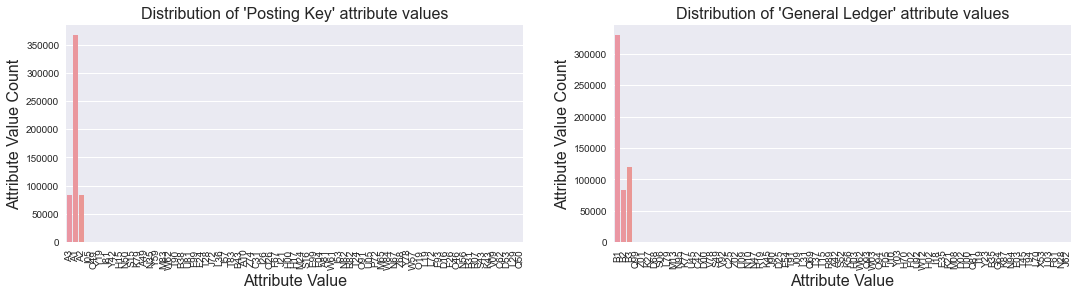

In [19]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(18)

# plot the distribution of the posting key attribute
plot = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])

# set axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Distribution of \'Posting Key\' attribute values', fontsize=16)

# plot the distribution of the general ledger attribute
plot = sns.countplot(x=ori_dataset['HKONT'], ax=ax[1])

# set axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Distribution of \'General Ledger\' attribute values', fontsize=16);

Unfortunately, neural networks are, in general, not designed to be trained directly on categorical data and require the attributes to be trained on to be numeric. One simple way to meet this requirement is by applying a technique referred to as **"one-hot" encoding**. Using this encoding technique, we will derive a numerical representation of each of the categorical attribute values. One-hot encoding creates new binary columns for each categorical attribute value present in the original data. 

Let's have a look at the example shown in **Figure 2** below. The **categorical attribute “Receiver”** below contains the names "Sally," "John" and "Emma". We "one-hot" encode the names by creating a separate binary column for each possible name-value observable in the "Receiver" column. Now, we encode for each transaction that contains the value "Sally" in the "Receiver" column this observation with 1.0 in the newly created "Sally" column and 0.0 in all other generated name columns.

<img align="middle" style="max-width: 600px; height: auto" src="./assets/encoding.png">

**Figure 2:** Exemplary one-hot encoding of the distinct `Receiver` attribute values into specific binary ("one-hot) columns. Thereby, each attribute value observable in the dataset results in a separate column. The column value `1.0` denotes the occurance of the attribute value in the corresponding journal entry. In contrast the column value `0.0` indicates the absence of the attribute value in the corresponding journal entry.

Using this technique will "one-hot" encode the six categorical attributes in the original transactional dataset. This can be achieved using the `get_dummies()` function available in the Pandas data science library:

In [20]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['BUKRS', 'KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_cat_processed = pd.get_dummies(ori_dataset[categorical_attr_names])

Finally, let's inspect the encoding of 10 sample transactions to see if the encoding was accomplished successfully;

In [21]:
# inspect encoded sample transactions
ori_dataset_cat_processed.head(10)

,BUKRS_A43,BUKRS_A89,BUKRS_B37,BUKRS_B76,BUKRS_C10,BUKRS_C11,BUKRS_C12,BUKRS_C13,BUKRS_C14,BUKRS_C15,...,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.3 Pre-Processing of Numerical Transaction Attributes

Let's now inspect the distributions of the two numerical attributes contained in the transactional dataset namely, the (1) local currency amount `DMBTR` and the (2) document currency amount `WRBTR`:

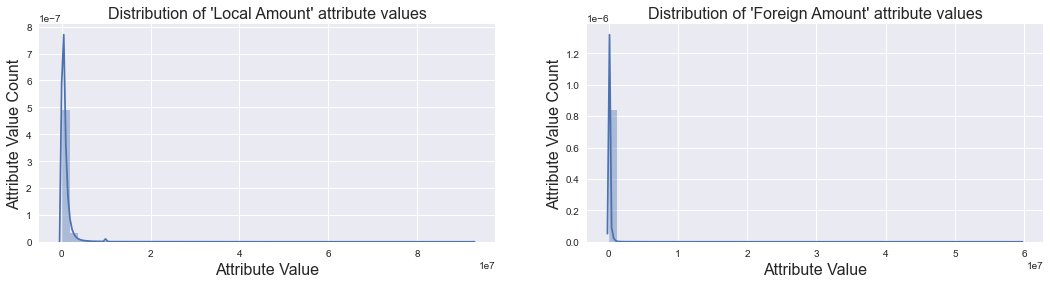

In [22]:
# plot the log-scaled "DMBTR" as well as the "WRBTR" attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(18)

# plot distribution of the local amount attribute
plot = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Distribution of \'Local Amount\' attribute values', fontsize=16)

# plot distribution of the document amount attribute
plot = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Distribution of \'Foreign Amount\' attribute values', fontsize=16);

As expected, it can be observed that for both attributes, the distributions of amount values are **heavy-tailed**. In order to approach faster a potential global minimum scaling and normalization of numerical input values is good practice. Therefore, we first log-scale both variables and second min-max normalize the scaled amounts to the interval [0, 1].

In [23]:
# select the 'DMBTR' and 'WRBTR' attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7

# log scale the 'DMBTR' and 'WRBTR' attribute values
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_num_processed = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

Let's now visualize the **log-scaled** and **min-max normalized** distributions of both attributes:

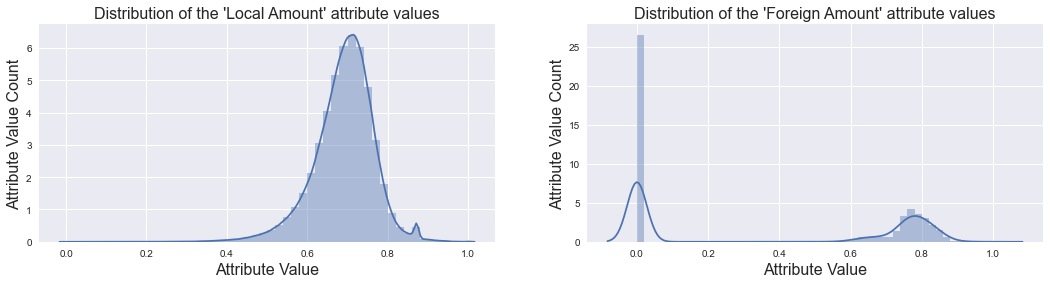

In [24]:
# plot the log-scaled "DMBTR" as well as the "WRBTR" attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(18)

# plot distribution of the local amount attribute
plot = sns.distplot(ori_dataset_num_processed['DMBTR'].tolist(), ax=ax[0])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Distribution of the \'Local Amount\' attribute values', fontsize=16)

# plot distribution of the document amount attribute
plot = sns.distplot(ori_dataset_num_processed['WRBTR'].tolist(), ax=ax[1])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Distribution of the \'Foreign Amount\' attribute values', fontsize=16);

### 3.4 Merge Categorical and Numerical Transaction Attributes

Finally, we merge both pre-processed numerical and categorical attributes into a single dataset that we will use for training our deep autoencoder neural network (explained an implemented in the following section 2):

In [25]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_cat_processed, ori_dataset_num_processed], axis = 1)

Now, let's again have a look at the dimensionality of the dataset after we applied the distinct pre-processing steps to the attributes:

In [26]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 618)

Ok, upon completion of all the pre-processing steps (excl. the exercises), we should end up with an encoded dataset consisting of a total number of **533,009 records** (rows) and **618 encoded attributes** (columns). Let's keep the number number of columns in mind since it will define the dimensionality of the input- and output-layer of our deep autoencoder network, which we will now implement in the following section.

## 4. Machine Learning Audit Data Analytics

The objective of this master class section is to familiarise ourselves with the underlying idea and concepts of building a deep **Autoencoder Neural Network (AENN)**. We will cover the primary building blocks and the specific network structure of AENNs as well as an exemplary implementation using the open-source machine learning library `PyTorch`.

<img align="center" style="max-width: 800px; height: auto" src="./assets/analytics.png">

### 4.1 Autoencoder Neural Network Architecture

AENNs or "Replicator Neural Networks" is a variant of general feed-forward neural networks that have been initially introduced by Hinton and Salakhutdinov in [6]. AENNs usually comprise a **symmetrical network architecture** as well as a central hidden layer, referred to as **"latent"** or **"coding" layer**, of lower dimensionality. The design is chosen intentionally since the training objective of an AENN is to reconstruct its input in an "unsupervised" training setup. **Figure 3** below illustrates a schematic view of an autoencoder neural network:

<img align="middle" style="max-width: 800px; height: auto" src="./assets/autoencoder.png">

**Figure 3:** Schematic view of an autoencoder network comprised of two non-linear mappings (fully connected feed forward neural networks) referred to as encoder $f_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$ and decoder $g_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dx}$.

Furthermore, AENNs can be interpreted as "lossy" data **compression algorithms**. They are "lossy" in a sense that the reconstructed outputs will be degraded compared to the original inputs. The difference between the original input $x^i$ and its reconstruction $\hat{x}^i$ is referred to as **reconstruction error**. In general, AENNs encompass three major building blocks:


>   1. an encoding mapping function $f_\theta$, 
>   2. a decoding mapping function $g_\theta$, 
>   3. and a loss function $\mathcal{L_{\theta}}$.

Most commonly the encoder and the decoder mapping functions consist of **several layers of neurons followed by a non-linear function** and shared parameters $\theta$. The encoder mapping $f_\theta(\cdot)$ maps an input vector (e.g. an "one-hot" encoded transaction) $x^i$ to a compressed representation $z^i$ referred to as latent space $Z$. This hidden representation $z^i$ is then mapped back by the decoder $g_\theta(\cdot)$ to a re-constructed vector $\hat{x}^i$ of the original input space (e.g. the re-constructed encoded transaction). Formally, the nonlinear mappings of the encoder- and the decoder-function can be defined by:

<center>$f_\theta(x^i) = s(Wx^i + b)$, and $g_\theta(z^i) = s′(W′z^i + d)$,</center>

where $s$ and $s′$ denote non-linear activations with model parameters $\theta = \{W, b, W', d\}$, $W \in \mathbb{R}^{d_x \times d_z}, W' \in \mathbb{R}^{d_z \times d_y}$ are weight matrices and $b \in \mathbb{R}^{dx}$, $d \in \mathbb{R}^{dz}$ are offset bias vectors.

### 4.2 Autoencoder Neural Network Implementation

Now, let's start implementing an `AENN model` by first implementing the encoder network using PyTorch. For the encoder, we aim to implement a network consisting of **nine fully-connected layers**. Furthermore, the encoder is specified by the following number of neurons per layer: "618-256-128-64-32-16-8-4-3". Meaning the first layer consists of 618 neurons (determined by the dimensionality of our input data), the second layer of 256 neurons and the subsequent layers of 128, 64, 32, 16, 8, 4 and 3 neurons respectively.

<img align="middle" style="max-width: 1000px; height: auto" src="./assets/neurons.png">

Some elements of the encoder network code below should be given particular attention:

>- `self.encoder_Lx`: defines the linear transformation of the layer applied to the incoming input: $Wx + b$.
>- `nn.init.xavier_uniform`: inits the layer weights using a uniform distribution according to [9]. 
>- `self.encoder_Rx`: defines the non-linear transformation of the layer: $\sigma(\cdot)$.
>- `self.dropout`: randomly zeros some of the elements of the input tensor with probability $p$ according to [8].

We use **"Leaky ReLUs"** as introduced by Xu et al. in [7] to avoid "dying" non-linearities and to speed up training convergence. Leaky ReLUs allow a small gradient even when a particular neuron is not active. Besides, we include the **"drop-out" probability**, as introduced by [8], which defines the probability rate for each neuron to be set to zero at a forward pass to prevent the network from overfitting. However, we explore its effect on the model later in the exercise section of the master class. Initially, we set the dropout probability of each neuron to $p=0.0$ (0%), meaning that none of the neuron activations will be set to zero.

In [27]:
# implementation of the encoder network
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 512
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=512, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 512, out 256
        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 256, out 128
        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 128, out 64
        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 64, out 32
        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 32, out 16
        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 16, out 8
        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform_(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 8, out 4
        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 4, out 3
        self.encoder_L9 = nn.Linear(4, 3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.dropout(self.encoder_L1(x)))
        x = self.encoder_R2(self.dropout(self.encoder_L2(x)))
        x = self.encoder_R3(self.dropout(self.encoder_L3(x)))
        x = self.encoder_R4(self.dropout(self.encoder_L4(x)))
        x = self.encoder_R5(self.dropout(self.encoder_L5(x)))
        x = self.encoder_R6(self.dropout(self.encoder_L6(x)))
        x = self.encoder_R7(self.dropout(self.encoder_L7(x)))
        x = self.encoder_R8(self.dropout(self.encoder_L8(x)))
        x = self.encoder_R9(self.encoder_L9(x)) # don't apply dropout to the AE bottleneck

        return x

Now, we are ready to instantiate the encoder model. The model will be pushed either on a CPU or available GPU by the execution of the following cell:

In [28]:
# intstantiate the encoder network model
encoder_train = encoder()

# push model to compute device
encoder_train = encoder_train.to(device)

Once the model is initialised, we can visualise the model structure and review the implemented network architecture by the execution of the following cell:

In [29]:
# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 2022.01.25-12:26:42] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=618, out_features=512, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L2): Linear(in_features=512, out_features=256, bias=True)
  (encoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L3): Linear(in_features=256, out_features=128, bias=True)
  (encoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L4): Linear(in_features=128, out_features=64, bias=True)
  (encoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L5): Linear(in_features=64, out_features=32, bias=True)
  (encoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L6): Linear(in_features=32, out_features=16, bias=True)
  (encoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L7): Linear(in_features=16, out_features=8, bias=True)
  (encoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L8): Linear(in_features=8, out_featu

Let's, now as a next step, complete the `AENN model` implementation by implementing the corresponding decoder network. The decoder also consists of nine fully-connected layers. Furthermore, the decoder network is intended to **symmetrically mirror** the encoder networks architecture by a layer-wise inversion "3-4-8-16-32-64-128-256" of the encoder network layers.

In [30]:
# implementation of the decoder network
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 4
        self.decoder_L1 = nn.Linear(in_features=3, out_features=4, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 4, out 8
        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 16
        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 16, out 32
        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 32, out 64
        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 64, out 128
        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform_(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify layer 7 - in 128, out 256
        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 256, out 512
        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform_(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 512, out 618
        self.decoder_L9 = nn.Linear(in_features=512, out_features=ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x))
        x = self.decoder_R2(self.dropout(self.decoder_L2(x)))
        x = self.decoder_R3(self.dropout(self.decoder_L3(x)))
        x = self.decoder_R4(self.dropout(self.decoder_L4(x)))
        x = self.decoder_R5(self.dropout(self.decoder_L5(x)))
        x = self.decoder_R6(self.dropout(self.decoder_L6(x)))
        x = self.decoder_R7(self.dropout(self.decoder_L7(x)))
        x = self.decoder_R8(self.dropout(self.decoder_L8(x)))
        x = self.decoder_R9(self.decoder_L9(x)) # don't apply dropout to the AE output
        
        return x

Let's also instantiate the encoder model for CPU or GPU training and convince ourselves that it was successfully initialised by printing and reviewing its architecture by the execution of the following cell:

In [31]:
# intstantiate the decoder network model
decoder_train = decoder()

# push model to compute device
decoder_train = decoder_train.to(device)
    
# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 2022.01.25-12:26:42] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=3, out_features=4, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L2): Linear(in_features=4, out_features=8, bias=True)
  (decoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L3): Linear(in_features=8, out_features=16, bias=True)
  (decoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L4): Linear(in_features=16, out_features=32, bias=True)
  (decoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L5): Linear(in_features=32, out_features=64, bias=True)
  (decoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L6): Linear(in_features=64, out_features=128, bias=True)
  (decoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L7): Linear(in_features=128, out_features=256, bias=True)
  (decoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L8): Linear(in_features=256, out_features=51

Looks like intended? Brilliant! Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [32]:
# init the number of encoder model parameters
encoder_num_params = 0

# iterate over the distinct encoder parameters
for param in encoder_train.parameters():

    # collect number of parameters
    encoder_num_params += param.numel()

# init the number of decoder model parameters
decoder_num_params = 0
    
# iterate over the distinct decoder parameters
for param in decoder_train.parameters():

    # collect number of parameters
    decoder_num_params += param.numel()
    
# print the number of model paramters
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] number of to be trained AENN model parameters: {}.'.format(now, encoder_num_params + decoder_num_params))

[LOG 2022.01.25-12:26:42] number of to be trained AENN model parameters: 985021.


Ok, our AENN model encompasses a total number **985'021 model parameters** to be trained.

### 4.3. Definition of the Training Loss Function and Learning Rate

Now that we have implemented the `AENN model` we are ready to train the network. Before starting the training, we need to define an appropriate loss function. Remember, we aim to train our model to learn a set of encoder-decoder model parameters $\theta$ that minimize the dissimilarity of a given financial transaction $x^{i}$ and its reconstruction $\hat{x}^{i} = g_\theta(f_\theta(x^{i}))$ as faithfully as possible. 

Thereby, the training objective is to learn a set of optimal shared encoder-decoder model parameters $\theta^*$ that optimize $\arg\min_{\theta} \|X - g_\theta(f_\theta(X))\|$ overall transactions or more specifically journal entries $X$. To achieve this optimisation objective, one typically minimises a loss function $\mathcal{L_{\theta}}$ as part of the network training. In this master class, we use the **binary-cross-entropy error (BCE)** loss, defined by:

<center> $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i}) = \frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{k} x^{i}_{j} ln(\hat{x}^{i}_{j}) + (1-x^{i}_{j}) ln(1-\hat{x}^{i}_{j})$, </center>

for a set of $n$-journal entries $x^{i}$, $i=1,...,n$ and their respective reconstructions $\hat{x}^{i}$ and all journal entry attributes $j=1,...,k$. During training, the BCE loss will penalise models that result in a high dissimilarity between input journal entries and their respective reconstructions. 

Luckily, an implementation of the BCE loss is already available in PyTorch! It can be instantiated "off-the-shelf" via execution of the following PyTorch command:

In [33]:
# define the optimization criterion / loss function
loss_function = nn.BCEWithLogitsLoss(reduction='mean')

# push the optimization criterion / loss function to compute device 
loss_function = loss_function.to(device)

(Note: Enabling the parameter `reduction` specifies that the losses are averaged over all observations for each minibatch).

Based on the loss magnitude of a certain mini-batch PyTorch automatically computes the gradients. Based on the gradient, the PyTorch library updates and optimises the AENN parameters $\theta$.

We will use the **Adam optimization** as proposed in [11] and set the learning-rate $l = 0.001$. Each mini-batch step the optimizer will update the encoder- and decoder-parameters $\theta$ values according to degree of reconstruction error. 

In [34]:
# set the learning rate
learning_rate = 1e-4

#set the paramete optimization strategy of both networks
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

Now that we have successfully implemented and defined the three building blocks of the `AENN model`. Let's take some time to review the `encoder` and `decoder` model definition as well as the `BCE loss`. Please, read the above code and comments carefully and don't hesitate to let us know any questions you might have.

## 5. Training the Autoencoder Neural Network (AENN) Model

In this section, we will train the deep `AENN model` (as implemented in section 4. of the master class) using the encoded transactional data (created in section 2. of the master class). More specifically, we will have a detailed look into the distinct training steps as well as how to monitor the training progress.

### 5.1 Preparing the Network Training

We have pre-processed the dataset, implemented the AENN and defined the reconstruction error. Let's now start to train a corresponding model for **5 epochs** and a **mini-batch size of 128** journal entries per batch. This training set up implies that the whole dataset will be fed to the AENN 5 times in chunks of 128 journal entries yielding to **4,165 mini-batches** (533,009 journal entries / 128 journal entries per mini-batch) per epoch.

In [35]:
# specify training parameters
num_epochs = 5
mini_batch_size = 128

During the training phase, we will fetch the individual mini-batches of the entire population of journal entries. To achieve this, we will use PyTorch's `DataLoader` that provides single- or multi-process iterators over a given dataset to load one mini-batch at a time. By enabling `shuffle=True`, the data will be shuffled at every epoch before feeding it to the network. 

In [36]:
# convert pre-processed transactional data to PyTorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# push pre-processed transactional data to compute device
torch_dataset = torch_dataset.to(device)

# init training dataloader
train_dataloader = dataloader.DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True)

### 5.2 Running the Network Training

Finally, we start training the model. The training procedure of each mini-batch is performed as follows: 

>1. do a forward pass through the encoder-decoder part, 
>2. compute the binary-cross-entropy reconstruction loss $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i})$, 
>3. do a backward pass through the encoder-decoder part, and 
>4. update the parameters of the encoder $f_\theta(\cdot)$ and decoder $g_\theta(\cdot)$ networks.

To ensure learning while training our `AENN model,` we will monitor whether the loss decreases with progressing training. Therefore, we obtain and evaluate the reconstruction performance of the entire dataset after each training epoch. Based on this evaluation, we can conclude the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:
 
>- `reconstruction_loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `encoder_optimizer.step()` and `decoder_optimizer.step()` updates the network parameters based on the gradient.

Also, after each training epoch, we want to save a checkpoint for both the actual `encoder` and `decoder` model. The saved model checkpoints contain a snapshot of the trained model parameter values upon completion of a training epoch. In general, it is good practice to keep checkpoints at regular intervals during training. In case your system crashes during training, you can continue from the last checkpoint rather than start over from scratch.

>- `torch.save()`: saves a checkpoint of the actual encoder and decoder model parameter values to disc.

In [37]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode (apply dropout when needed)
encoder_train.train()
decoder_train.train()

# init the best loss by setting it to infinity
best_loss = np.inf

# train autoencoder model
for epoch in range(num_epochs):

    # init collection of epoch losses
    train_mini_batch_losses = []
    
    # init mini batch counter
    mini_batch_count = 0
        
    # iterate over all mini-batches
    for mini_batch_data in train_dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # push mini batch data to compute device
        mini_batch_data = mini_batch_data.to(device)

        # =================== (1) forward pass ===================================

        # run forward pass
        z_representation = encoder_train(mini_batch_data) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data
        
        # =================== (2) compute reconstruction loss ====================

        # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_data)
        
        # =================== (3) backward pass ==================================

        # reset graph gradients
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()
        
        # =================== (4) update model parameters ========================

        # update network parameters
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== monitor training progress ==========================

        # print training progress each 1.000 mini-batches
        if mini_batch_count % 1000 == 0:
            
            # print mini batch reconstuction results
            now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
            print('[LOG {}] epoch: [{}/{}], batch: {}, batch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(mini_batch_count), str(np.round(reconstruction_loss.item(), 8))))
            
        # collect mini-batch loss
        train_mini_batch_losses.extend([reconstruction_loss.item()])

    # =================== evaluate model performance =============================
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
                                 
    # print training epoch results
    now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
    print('[LOG {}] epoch: [{}/{}], epoch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(train_epoch_loss, 8))))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)
    
    # =================== save model snapshot to disk ============================
    
    # case: new best model trained
    if train_epoch_loss < best_loss:
    
        # save trained encoder model file to disk
        encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
        torch.save(encoder_train.state_dict(), os.path.join(models_directory, encoder_model_name))

        # save trained decoder model file to disk
        decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
        torch.save(decoder_train.state_dict(), os.path.join(models_directory, decoder_model_name))
        
        # update best loss
        best_loss = train_epoch_loss

        # print epoch loss
        now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
        print('[LOG {}] epoch: [{}/{}], new best epoch-train-loss: {} found'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(train_epoch_loss, 8))))

[LOG 2022.01.25-12:27:09] epoch: [1/5], batch: 1000, batch-train-loss: 0.02901251
[LOG 2022.01.25-12:27:35] epoch: [1/5], batch: 2000, batch-train-loss: 0.0214283
[LOG 2022.01.25-12:28:01] epoch: [1/5], batch: 3000, batch-train-loss: 0.02004941
[LOG 2022.01.25-12:28:30] epoch: [1/5], batch: 4000, batch-train-loss: 0.01755199
[LOG 2022.01.25-12:28:35] epoch: [1/5], epoch-train-loss: 0.03506086
[LOG 2022.01.25-12:28:35] epoch: [1/5], new best epoch-train-loss: 0.03506086 found
[LOG 2022.01.25-12:29:08] epoch: [2/5], batch: 1000, batch-train-loss: 0.01669479
[LOG 2022.01.25-12:29:44] epoch: [2/5], batch: 2000, batch-train-loss: 0.01457508
[LOG 2022.01.25-12:30:22] epoch: [2/5], batch: 3000, batch-train-loss: 0.01519034
[LOG 2022.01.25-12:31:04] epoch: [2/5], batch: 4000, batch-train-loss: 0.01407933
[LOG 2022.01.25-12:31:12] epoch: [2/5], epoch-train-loss: 0.01565332
[LOG 2022.01.25-12:31:12] epoch: [2/5], new best epoch-train-loss: 0.01565332 found
[LOG 2022.01.25-12:31:54] epoch: [3/5],

Let's now visualise the loss magnitude obtained for each training epoch:

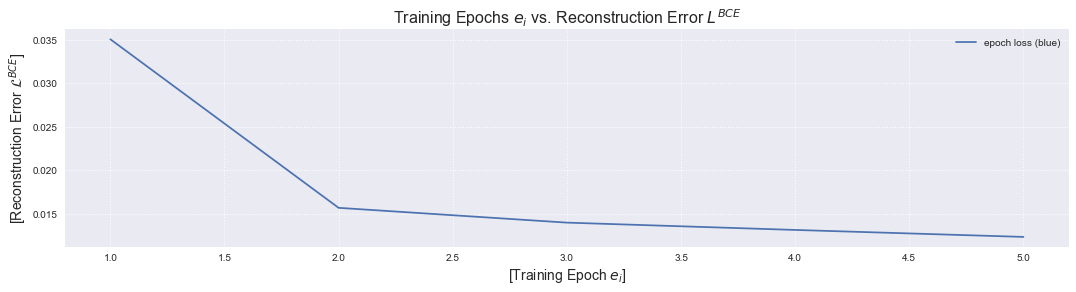

In [38]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(18)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' prediction error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[Training Epoch $e_i$]", fontsize=14)
ax.set_ylabel("[Reconstruction Error $\mathcal{L}^{BCE}$]", fontsize=14)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Reconstruction Error $L^{BCE}$', fontsize=16);

It can be observed that, after training the `AENN model` for five training epochs, the reconstruction error starts to decrease. This observation indicates that the model already did an excellent job in learning the distinct attribute pattern of the journal entries. However, judging from the loss visualisation above it can also conclude that, the model could probably be trained a couple more epochs as the reconstruction error continues to decrease.

## 6. Evaluating the Model's Anomaly Detection Capability

In this section, we will evaluate the anomaly detection capability of the (pre-trained) `AENN model`. The comparison will encompass the **local** as well as the **global anomalies** contained in the dataset of journal entries. 

### 6.1 Loading a (pre-trained) Model Checkpoint

Before starting our evaluation, let's load the best performing `AENN model` or an already pre-trained model (as done below). Remember, that we stored a snapshot of the model parameters after each training epoch to our local model directory. We will now load one of the pre-trained checkpoints that was trained for **30 training epochs**:

In [39]:
# restore pretrained model checkpoint
encoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/courseAAA/main/04_models/ep_30_encoder_model.pth'
decoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/courseAAA/main/04_models/ep_30_decoder_model.pth'

# read stored model from the remote location
encoder_bytes = urllib.request.urlopen(encoder_model_name)
decoder_bytes = urllib.request.urlopen(decoder_model_name)

# load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read())
decoder_buffer = io.BytesIO(decoder_bytes.read())

# init evaluation encoder and decoder model
encoder_eval = encoder()
decoder_eval = decoder()

# push encoder and decoder model to compute device
encoder_eval = encoder_eval.to(device)
decoder_eval = decoder_eval.to(device)

# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer, map_location=lambda storage, loc: storage))
decoder_eval.load_state_dict(torch.load(decoder_buffer, map_location=lambda storage, loc: storage))

<All keys matched successfully>

### 6.2 Evaluation of the (pre-trained) Model

Once obtained, let's push the model, the loss function, and the dataset to the `CPU` for validation purposes. This will allow us the compute all the individual reconstructions of the journal entry dataset in one go without the potential limitations of the `GPU` RAM:

In [40]:
# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# push encoder and decoder model to compute device
encoder_eval = encoder_eval.to('cpu')
decoder_eval = decoder_eval.to('cpu')

# push the dataset to the CPU 
torch_dataset = torch_dataset.to('cpu')

# push the loss function to the CPU
loss_function = loss_function.to('cpu')

Ok, great that went smoothly.

### 6.3 Assessment of the Individual Journal Entries

Let's assess the **reconstruction quality of individual journal entries** of the dataset. To achieve this, we first collect the reconstruction of each individual journal entry. Afterwards, the obtained reconstructions are compared to the original journal entries. Thereby, the reconstruction loss of each individual journal entry is collected: 

In [41]:
# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(torch_dataset))

# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], torch_dataset[i]).item()

    if(i % 100000 == 0):

        ### print conversion summary
        now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))

[LOG 2022.01.25-12:40:57] collected individual reconstruction loss of: 000000/533009 transactions
[LOG 2022.01.25-12:41:04] collected individual reconstruction loss of: 100000/533009 transactions
[LOG 2022.01.25-12:41:11] collected individual reconstruction loss of: 200000/533009 transactions
[LOG 2022.01.25-12:41:19] collected individual reconstruction loss of: 300000/533009 transactions
[LOG 2022.01.25-12:41:26] collected individual reconstruction loss of: 400000/533009 transactions
[LOG 2022.01.25-12:41:32] collected individual reconstruction loss of: 500000/533009 transactions


Once we have collected individual reconstruction errors, let's visualise them accordingly:

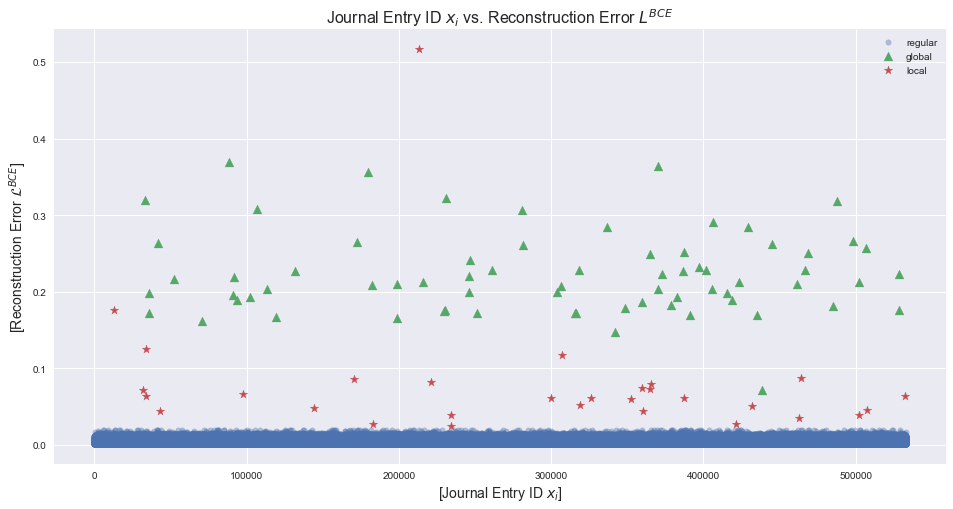

In [65]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# set plot size
fig.set_figwidth(16)
fig.set_figheight(8)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

# obtain regular transactions as well as global and local anomalies
regular_data = plot_data[label == 'regular']
global_outliers = plot_data[label == 'global']
local_outliers = plot_data[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o", s=30, label='regular') # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", s=80, label='global') # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="*", s=80, label='local') # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best')

# add axis legends
ax.set_xlabel("[Journal Entry ID $x_i$]", fontsize=14)
ax.set_ylabel("[Reconstruction Error $\mathcal{L}^{BCE}$]", fontsize=14)

# add plot title
plt.title('Journal Entry ID $x_i$ vs. Reconstruction Error $L^{BCE}$', fontsize=16);

The visualisation reveals that the pre-trained model can reconstruct the majority of regular journal entries while failing to do so, for the anomalous ones. As a result, the model reconstruction error can be used to distinguish both **"global" anomalies (green)** and **"local" anomalies (red)** from the regular journal entries (blue).

To further investigate our observation and confirm the initial assumption, let's have a closer look into the journal entries exhibiting a **binary cross-entropy reconstruction error greater or equal to 0.15**. We assume that these journal entries correspond to the **"global" anomalies** of the original dataset:

In [43]:
# append labels to original dataset
ori_dataset['label'] = label

# extract transactions exhibiting a reconstruction error >= 0.15
autoencoder_global_anomalies = ori_dataset[reconstruction_loss_transaction >= 0.15]

# inspect transactions exhibiting a reconstruction error >= 0.15
autoencoder_global_anomalies

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
12939,532980,C1,C20,C1,C18,A1,B1,9.106583e+05,5.444984e+04,local
33365,532942,W59,C13,P83,I73,I05,Q99,9.244552e+07,5.958504e+07,global
35691,532967,M07,S42,J81,A14,O49,Z01,9.244553e+07,5.958503e+07,global
35944,532917,J82,Q22,P32,Z74,Y19,K27,9.244553e+07,5.958504e+07,global
41925,532923,T17,R47,D84,F38,I81,D68,9.244552e+07,5.958505e+07,global
...,...,...,...,...,...,...,...,...,...,...
498175,532963,Z06,G77,Z22,R09,V09,X53,9.244553e+07,5.958504e+07,global
502255,532954,J38,C30,G28,T38,C62,L03,9.244551e+07,5.958503e+07,global
506926,532948,U72,D58,E35,Y05,D53,F61,9.244551e+07,5.958505e+07,global
528449,532959,C89,S43,E40,Y34,L29,N28,9.244553e+07,5.958504e+07,global


Let's extract the filtered transactions into an excel spreadsheet for a further sample based testing by the audit team. Therefore, we will in a first step create a time stamp of the data extract for audit trail purposes:

In [44]:
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

Now, we extract the filtered **global anomaly** journal entries as an excel spreadsheet to the local file system for further inspection:

In [45]:
# specify the filename of the excel spreadsheet
filename = str(timestamp) + " - ACA_001_autoencoder_global_anomalies.xlsx"

# specify the target data directory of the excel spreadsheet
data_directory = os.path.join(results_directory, filename)

# extract the filtered transactions to excel
autoencoder_global_anomalies.to_excel(data_directory, header=True, index=False, sheet_name="Global_Anomalies", encoding="utf-8")

Let's now also have a closer look into the journal entries exhibiting a **binary cross-entropy reconstruction error greater or equal to 0.02 but less than 0.15**. We assume that these journal entries mostly correspond to the **"local" anomalies** of the original dataset:

In [46]:
# extract transactions exhibiting a reconstruction error < 0.15 and >= 0.02
autoencoder_local_anomalies = ori_dataset[(reconstruction_loss_transaction >= 0.02) & (reconstruction_loss_transaction < 0.15)]

# inspect transactions exhibiting a reconstruction error < 0.15 and >= 0.02
autoencoder_local_anomalies

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
32317,532989,C1,C11,C1,C53,A1,B1,9.106530e+05,5.443921e+04,local
34058,532991,C1,C11,C1,C91,A1,B1,9.106689e+05,5.444086e+04,local
34059,533003,C1,C11,C1,C64,A1,B1,9.106316e+05,5.444328e+04,local
43399,532998,C1,C11,C1,C79,A1,B1,9.106504e+05,5.443506e+04,local
97954,532984,C1,C11,C1,C68,A1,B1,9.106486e+05,5.444262e+04,local
144286,532994,C1,C11,C1,C76,A1,B1,9.106451e+05,5.444844e+04,local
170320,533001,C1,C11,C1,C30,A1,B1,9.106460e+05,5.445281e+04,local
183064,533006,C1,C11,C1,C82,A1,B1,9.106489e+05,5.443671e+04,local
220927,533002,C1,C11,C1,C60,A1,B1,9.106485e+05,5.444638e+04,local
234335,532987,C1,C11,C1,C80,A1,B1,9.106476e+05,5.444611e+04,local


Let's again extract the filtered transactions into an excel spreadsheet for a further sample based testing by the audit team. Therefore, we will in a first step create a time stamp of the data extract for audit trail purposes:

In [47]:
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

Now, we extract the filtered **local anomaly** journal entries as an excel spreadsheet to the local file system for further inspection:

In [48]:
# specify the filename of the excel spreadsheet
filename = str(timestamp) + " - ACA_002_autoencoder_local_anomalies.xlsx"

# specify the target data directory of the excel spreadsheet
data_directory = os.path.join(results_directory, filename)

# extract the filtered transactions to excel
autoencoder_local_anomalies.to_excel(data_directory, header=True, index=False, sheet_name="Local_Anomalies", encoding="utf-8")

## 7. Evaluating the Model's Latent Space Representations

In a real-world scenario, it is usually also beneficial to inspect the latent space representations of each individual journal entry that was learned by the `AENN model`. This to determine if the autoencoder learned a meaningful representation and to obtain an impression of the structural characteristics evident in the data. To achieve this, we will propagate the journal entries through the encoder network of the trained model to obtain the respective **latent space representation** for each entry (also referred to as "embedding", (the activation pattern of each journal entry at the bottleneck neurons).

We will now load one, even longer pre-trained checkpoint, that was trained for a total of **80 training epochs**:

In [49]:
# restore pretrained model checkpoint
encoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/courseAAA/main/04_models/ep_80_encoder_model.pth'
decoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/courseAAA/main/04_models/ep_80_decoder_model.pth'

# read stored model from the remote location
encoder_bytes = urllib.request.urlopen(encoder_model_name)
decoder_bytes = urllib.request.urlopen(decoder_model_name)

# load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read())
decoder_buffer = io.BytesIO(decoder_bytes.read())

# init evaluation encoder and decoder model
encoder_eval = encoder()
decoder_eval = decoder()

# push encoder and decoder model to compute device
encoder_eval = encoder_eval.to('cpu')
decoder_eval = decoder_eval.to('cpu')

# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer, map_location=lambda storage, loc: storage))
decoder_eval.load_state_dict(torch.load(decoder_buffer, map_location=lambda storage, loc: storage))

<All keys matched successfully>

Let's obtain the distinct representations of the journal entries and convert them to Pandas `DataFrame`:

In [50]:
# push the dataset to the CPU 
torch_dataset = torch_dataset.to('cpu')

# run forward path through encoder to obtain journal entry representations
entry_representations = encoder_eval(torch_dataset)

# convert the representations to a pandas dataframe
entry_representation = pd.DataFrame(entry_representations.data.cpu().numpy(), columns=['z1', 'z2', 'z3'])

Furthermore, let's add the original labels of each journal entry to the obtained representations:

In [51]:
entry_representation['label'] = label

Inspect the first ten obtained representations and corresponding labels: 

In [52]:
entry_representation.head(10)

,z1,z2,z3,label
0,-20.440016,69.091934,140.987885,regular
1,-31.891876,124.219872,176.576233,regular
2,-45.692776,185.556519,143.998108,regular
3,-17.200094,51.422825,118.995628,regular
4,-5.799129,11.201353,69.737755,regular
5,-27.979187,105.862213,170.892471,regular
6,-16.255836,58.292408,25.024446,regular
7,-0.658805,-7.603784,114.875496,regular
8,-14.706062,43.125275,101.367447,regular
9,-13.998024,42.745930,106.522575,regular


When designing the AENN model architecture, we intentionally chose a bottleneck layer consisting of **3 neurons**. This provides us with the ability to visualise the distinctive activation pattern using the 3d plotting capabilities of Python's `Matplotlib` library.

Let's draw an interactive 3d scatter plot of the latent space representations:

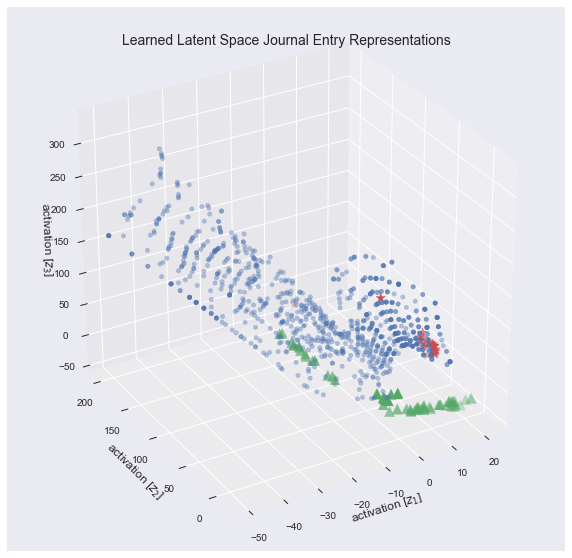

In [63]:
# enforce inline plotting
%matplotlib inline

# import 3d plotting and animation libraries
from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.mplot3d import axes3d

# init the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# change plot perspective
ax.view_init(elev=30, azim=240)

# set axis paramaters of subplot
ax.grid(linestyle='dotted')

# plot regular transactions, just the first 1000 to gain an intuition
regular = entry_representation[entry_representation['label'] == 'regular']
ax.scatter(regular['z1'][0:1000], regular['z2'][0:1000], regular['z3'][0:1000], c='C0', alpha=0.4, marker="o")

# plot first order anomalous transactions
global_anomalies = entry_representation[entry_representation['label'] == 'global']
ax.scatter(global_anomalies['z1'], global_anomalies['z2'], global_anomalies['z3'], c='C1', s=100, marker="^")

# plot second order anomalous transactions
local_anomalies = entry_representation[entry_representation['label'] == 'local']
ax.scatter(local_anomalies['z1'], local_anomalies['z2'], local_anomalies['z3'], c='C2', s=100, marker="*")

# set axis labels
ax.set_xlabel('activation [$z_1$]', weight='normal', fontsize=12)
ax.set_ylabel('activation [$z_2$]', weight='normal', fontsize=12)
ax.set_zlabel('activation [$z_3$]', weight='normal', fontsize=12)

# set plot title
plt.title('Learned Latent Space Journal Entry Representations', fontsize=14);

# animate 3D latent space representations
#def animate(frame):
#  ax.view_init(30, frame/4)
#  plt.pause(.001)
#  return fig

# create html animation
#anim = animation.FuncAnimation(fig, animate, frames=500, interval=50)
#HTML(anim.to_html5_video())

## Exercises:

We recommend you to try the following exercises as part of the master class:

**1. Apply a `dropout` throughout the network training.**

>Set the `dropout` probability to `0.2` (20%) and re-start the training procedure. What impact do you observe in terms of training performance and reconstruction loss? Please, note that after changing the `dropout` probability of the encoder and decoder model you need to execute all successive cells starting from section 4.2.

In [54]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**2. Train and evaluate a `shallow` autoencoder model.**

> The master class model architecture resulted in a good anomaly detection accuracy. Let's see how the reconstruction performance change if **several of the hidden layers** will be removed. First, adjust the encoder and decoder model definitions in section 4.2 accordingly (you may want to use the code snippets shown below). Then, follow all the instructions for training from scratch. Please note that after altering the encoder and decoder network architecture in section 4.2, you need to execute all successive cells starting from section 4.2.

In [55]:
# implementation of the shallow encoder network 
# containing only a single layer
class shallow_encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 3
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=3, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x)) # don't apply dropout to the AE bottleneck

        return x
    
# implementation of the shallow decoder network 
# containing only a single layer
class shallow_decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 618
        self.decoder_L1 = nn.Linear(in_features=3, out_features=ori_subset_transformed.shape[1], bias=True) # add linearity 
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x)) # don't apply dropout to the AE output
        
        return x

In [56]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

## Master Class Summary:

In this master class, a step by step introduction into **design, implementation, training and evaluation** of an autoencoder neural network-based anomaly detection approach is presented. The trained autoencoder neural network's reconstruction error obtainable for each journal entry can be interpreted as a highly adaptive anomaly assessment. The code provided in this class offers a blueprint for the development and testing of more complex anomaly detection strategies.

You may want to execute the code of the notebook outside of the Jupyter notebook environment, e.g. on a compute node or a server. The cell below converts the notebook into a standalone and executable python script. Pls. note that to convert the notebook, you need to install Python's **nbconvert** library and its extensions:

In [57]:
# installing the nbconvert library (uncomment the following statements if needed)
# !pip3 install nbconvert
# !pip3 install jupyter_contrib_nbextensions

Let's now convert the Jupyter notebook into a plain Python script:

In [58]:
!jupyter nbconvert --to script aaa_lab.ipynb

[NbConvertApp] Converting notebook aaa_lab.ipynb to script
[NbConvertApp] Writing 66145 bytes to aaa_lab.py


## Literature:

Major elements of the lab content are inspired by the publication ***Detection of Anomalies in Large Scale Accounting Data using Deep Autoencoder Networks***, of M. Schreyer, T. Sattarov, D. S. Borth, A. Dengel, and B. Reimer, 2017 (arXiv preprint available under: https://arxiv.org/abs/1709.05254).

[1] ACFE, ***Report to the Nations on Occupational Fraud and Abuse***, The 2016 Global Fraud Study, Association of Certified Fraud Examiners (ACFE), 2016.

[2] J. T. Wells, ***Corporate Fraud Handbook: Prevention and Detection***, John Wiley & Sons, 2017.

[3] PwC, ***Pulling Fraud Out of the Shadows***, The Global Economic Crime and Fraud Survey 2018, PricewaterhouseCoopers LLP, 2018.

[4] S. Markovitch, P. Willmott, ***Accelerating the Digitization of Business Processes***, McKinsey & Company (2014) 1–5.

[5] SAP, SAP Global Corporate Affairs, Corporate Factsheet 2017, 2017.

[6] E. A. Lopez-Rojas , A. Elmir, and S. Axelsson, ***PaySim: A Financial Mobile Money Simulator for Fraud Detection***, In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus, 2016.

[7] G. E. Hinton, and R. R. Salakhutdinov, ***Reducing the Dimensionality of Data With Neural Networks***, science 313, no. 5786: 504-507, 2006.

[8] N. Srivastava, G. E. Hinton, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, ***Dropout: A Simple Way to Prevent Neural Networks from Overfitting***, The Journal of Machine Learning Research, 15(1), 1929-1958, 2014.

[9] X. Glorot and Y. Bengio, ***Understanding the Difficulty of Training Deep Feedforward Neural Networks***, Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (AISTATS), 9:249–256, 2010.

[10] B. Xu, N. Wang, T. Chen, and M. Li, ***Empirical Evaluation of Rectified Activations in Convolution Network***, ICML Deep Learning Workshop, pages 1–5, 2015.

[11] D. P. Kingma and J. Ba, ***ADAM: A Method for Stochastic Optimization***, International Conference on Learning Representations (ICLR). 2015.

[12] G. E. Hinton, N. Srivastava, A. Krizhevsky, I. Sutskever, R. R. Salakhutdinov. ***Improving Neural Networks by Preventing Co-Adaptation of Feature Detectors***, Technical Report, 2012.

[13] D. P. Kingma, M. Welling. ***Auto-encoding Variational Bayes***, arXiv preprint arXiv:1312.6114, 2013.

[14] Makhzani, A., Shlens, J., Jaitly, N., Goodfellow, I., & Frey, B., ***Adversarial Autoencoders***, arXiv preprint arXiv:1511.05644, 2015.